# DC-DC Buck converter 

The goal is to compare the SIMBA simulation results against theory calculation for this topology.

Let's compare the output voltage and rms current through the inductance.

# SIMBA circuit
![buck](buck.png)



Simulation settings : 
* predictive time step (variable) 
* minimum time step: 1E-06
* simulation time: we use the "stop at steady state" function


# Theory calculation

* Output voltage

$ V_{out} =  V_{in} \times D $

with:

V_in = 50

D = duty cycle = 0.5 

* Inductance RMS current

$ I_{ind,rms} = \sqrt{\frac{(Iind,moy)² + (deltaIl)²}{12}}  $

with 

R = 5

L = 0.001

fswitch = 5000

$ Iind,moy = \frac{D \times Vin}{R} $

$ deltaIl= \frac{D \times (1-D) \times Vin}{L*fswitch} $


### Run Simulation 

In [1]:
# Load modules
from aesim.simba import JsonProjectRepository
from math import *
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
#Theory calculation for output average voltage and rms current through the inductance

Vinput = 50
Duty=0.5
Vo_th = Vinput * Duty
print ("Theory Output voltage for continous conduction = ", Vo_th)

R_th = 5
L_th = 0.001
fswitch_th = 5000
Iinductance_moy = (Duty*Vinput)/R_th
deltaIl= Duty * (1-Duty) * Vinput/(L_th*fswitch_th)
Iind_rms_th = sqrt((Iinductance_moy*Iinductance_moy) + (deltaIl*deltaIl)/12)
print ("Theory Inductance current rms = ", Iind_rms_th)

Theory Output voltage for continous conduction =  25.0
Theory Inductance current rms =  5.0518148554092255


In [3]:
# Load functions

# get steady state signals
def steadystate_signal(horizon_time, time, *signals):
    """steadystate_signal() returns time ndarray and a list of signals on the horizon_time"""

    steadystate_maskarray = np.ma.where(time > time[-1] - horizon_time)
    steadystate_time = time[steadystate_maskarray]
    steadystate_signal_list = [signal[steadystate_maskarray] 
for signal in signals]
    return steadystate_time, *steadystate_signal_list

# calculate average value
def average_value(time, waveform):
    """average_value() returns the average value of a time waveform equal time steps are not required"""

    cum_sum = 0
    range_idx = range(0, len(time)-1, 1)

    for idx in range_idx:
        cum_sum += (time[idx + 1] - time[idx]) * (waveform[idx+1] + waveform[idx]) /2
    return (1 / (time[-1] - time[0]) * cum_sum)

# calculate rms value
def rms_value(time, waveform):
    """rms_value() returns the rms value of a time waveform equal time steps are not required"""

    cum_sum = 0
    range_idx = range(0, len(time)-1, 1)

    for idx in range_idx:
        cum_sum += (time[idx + 1] - time[idx]) * (waveform[idx+1]**2 + waveform[idx]**2) /2
    return (np.sqrt(1 / (time[-1] - time[0]) * cum_sum))

# plot histogram
def plot_bar(Tab1 = [], 
        Tab2 = [], 
        largeur_barre = 0.3,
        Etiquette = [],
        FigAxe = "ax1",
        show = False,
        plot = plt, Tab1_abscisse = [], 
        dxticks = 0, mxticks = 2, 
        xlim = [], ylim = [],
        color_tab1 = 'orange',
        Legend = ['SIMBA', 'PSIM'],
        ylabel='Average or rms values'):
        """
        Tab1: donnée SIMBA
        Tab2: Donnée PSIM
        largeur_barre = 0.3 # Largeur de chaque barre :
        """

        if Tab1_abscisse == []:
                Tab1_abscisse = range(len(Tab1)) # Position des barres de la categorie 1
        
        if Tab2 != []:
                Tab2_abscisse = [i + largeur_barre for i in Tab1_abscisse] # Position des barres de la cat 2

        plot.bar(Tab1_abscisse, Tab1, width = largeur_barre, color = color_tab1, # Barres cat 1
                edgecolor = 'black', linewidth = 2)
        
        if Tab2 != []:
                plot.bar(Tab2_abscisse, Tab2, width = largeur_barre, color = 'yellow', # Barres cat 2
                        edgecolor = ['black' for i in Tab1], linewidth = 2)

        plot.xticks([dxticks+r + largeur_barre / mxticks for r in range(len(Tab1))], # Etiquettes
                Etiquette)

        FigAxe.set_ylabel(ylabel)

        if ylim !=[]:
                plt.ylim(ylim)
        if xlim !=[]:
                plt.xlim(xlim)

        if Tab2 != []:
            plot.legend(Legend)

        if show == True :
                plot.show()


========== 0 Error(s), 0 Warning(s) ==========
Job duration: 0,006636 seconds.

SIMBA Output Voltage rms in steady state =  24.997433885144634
SIMBA Inductance rms current in steady state =  5.053641840309184
 Diff_relative_rms for output voltage at steady state=  0.01026
 Diff_relative_rms for inductance current at steady state=  0.03616
Total simulation Time in SIMBA 0.006636


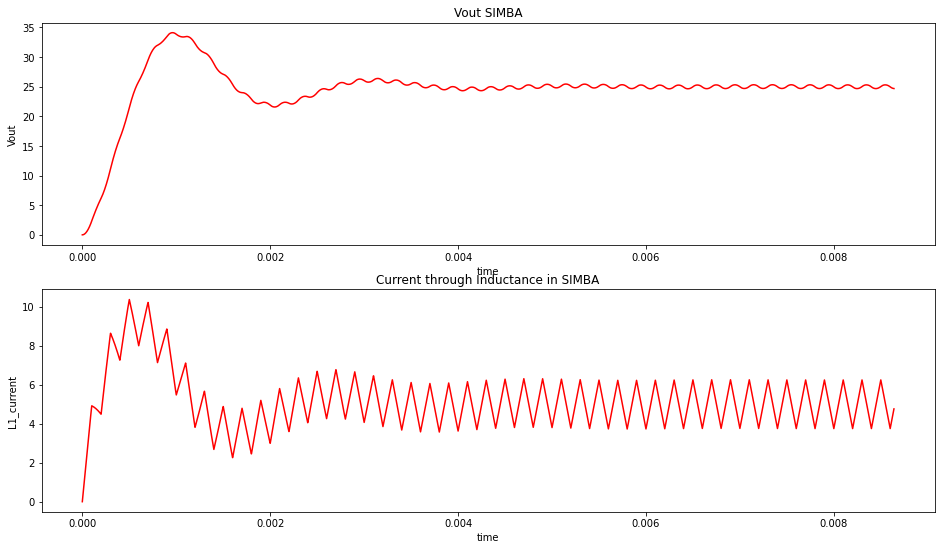

In [4]:
# Load SIMBA project
file_path = os.path.join(os.getcwd(), "buck.jsimba")
project = JsonProjectRepository(file_path)
dcdc_buck = project.GetDesignByName('dcdc_buck')

# Get the job object and solve the system
job = dcdc_buck.TransientAnalysis.NewJob()
status = job.Run()
print(job.Summary())

# Get results
t = job.TimePoints
Vout = job.GetSignalByName('R1 - Instantaneous Voltage').DataPoints
L1_current = job.GetSignalByName('L1 - Instantaneous Current').DataPoints


# Plot graph for output voltage and inductance current during all simulation time
fig = plt.figure(figsize = (16, 9))

ax1 = fig.add_subplot(211)
plot1 = ax1.plot(t, Vout, "r")
ax1.set_xlabel('time')
ax1.set_ylabel('Vout')
ax1.set_title("Vout SIMBA")

ax4 = fig.add_subplot(212)
plot1 = ax4.plot(t, L1_current, "r")
ax4.set_xlabel('time')
ax4.set_ylabel('L1_current')
ax4.set_title("Current through Inductance in SIMBA")


# steady state during 2 periods for the measurements comparison
fsw=5000
horizon_time = 2 / fsw  
t, Vout, L1_current = steadystate_signal(
   horizon_time,
   np.array(job.TimePoints),
   np.array(job.GetSignalByName('R1 - Instantaneous Voltage').DataPoints),
   np.array(job.GetSignalByName('L1 - Instantaneous Current').DataPoints))

# Perform rms calculation during 2 periods
Vout_rms = rms_value(t, Vout)
print("SIMBA Output Voltage rms in steady state = ", str(Vout_rms))

L1_current_rms =  rms_value (t,L1_current)
print("SIMBA Inductance rms current in steady state = ", str(L1_current_rms))

# calculation of relative difference between SIMBA & theoretical calculation at steady state
Diff_relative_rms1 = np.round(abs(Vo_th - Vout_rms)*100/Vo_th, 5)
print (" Diff_relative_rms for output voltage at steady state= ", Diff_relative_rms1)

Diff_relative_rms = np.round(abs(Iind_rms_th - L1_current_rms)*100/Iind_rms_th, 5)
print (" Diff_relative_rms for inductance current at steady state= ", Diff_relative_rms)


#Retrieve total simulation time for SIMBA simulation
job.RunTime
print ("Total simulation Time in SIMBA", str(job.RunTime))


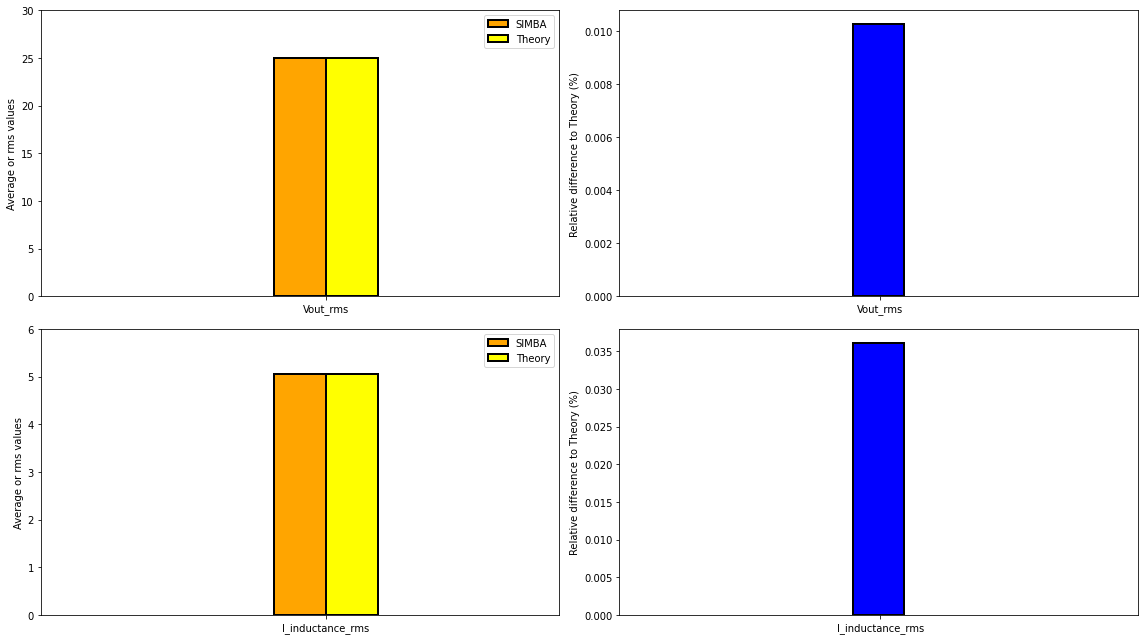

In [5]:
# Plot figure with both graphs and Histogram at steady state
fig1 = plt.figure(figsize = (16, 9))
ax2 = fig1.add_subplot(221)
plot_bar(Tab1 = [Vout_rms],
        Tab2 = [Vo_th], 
        largeur_barre = 0.1,
        Etiquette = ['Vout_rms'],
        Legend = ['SIMBA', 'Theory'],
        xlim = [0, 1], ylim = [0, 30],
        Tab1_abscisse = [0.5], 
        dxticks= 0.5,
        FigAxe = ax2)



ax3 = fig1.add_subplot(222)
plot_bar(Tab1 = [Diff_relative_rms1], 
        largeur_barre = 0.1,
        Etiquette = ['Vout_rms'],
        FigAxe = ax3, 
        mxticks = 32,
        ylabel = 'Relative difference to Theory (%)',
        Tab1_abscisse = [0.5],
        xlim = [0, 1],
        dxticks= 0.5,
        color_tab1 = 'blue')


ax5 = fig1.add_subplot(223)
plot_bar(Tab1 = [L1_current_rms],
        Tab2 = [Iind_rms_th], 
        largeur_barre = 0.1,
        Etiquette = ['I_inductance_rms'],
        Legend = ['SIMBA', 'Theory'],
        xlim = [0, 1], ylim = [0, 6],
        Tab1_abscisse = [0.5], 
        dxticks= 0.5,
        FigAxe = ax5)



ax6 = fig1.add_subplot(224)
plot_bar(Tab1 = [Diff_relative_rms], 
        largeur_barre = 0.1,
        Etiquette = ['I_inductance_rms'],
        FigAxe = ax6, 
        mxticks = 32,
        ylabel = 'Relative difference to Theory (%)',
        Tab1_abscisse = [0.5],
        xlim = [0, 1],
        dxticks= 0.5,
        color_tab1 = 'blue')

fig.tight_layout()
fig1.tight_layout()

plt.show()